In [22]:
from typing import List, TypedDict
import time

from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain.chat_models import init_chat_model
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_text_splitters import RecursiveCharacterTextSplitter

from langgraph.graph import START, END, StateGraph
from dotenv import load_dotenv

from langchain_ollama import ChatOllama

from pydantic import BaseModel
import re

from langchain_community.tools.tavily_search import TavilySearchResults

load_dotenv()

True

In [13]:
docs = (
    PyPDFLoader("./docs/book1.pdf").load() +
    PyPDFLoader("./docs/book2.pdf").load() +
    PyPDFLoader("./docs/book3.pdf").load()
)

In [14]:
chunks = RecursiveCharacterTextSplitter(chunk_size = 900, chunk_overlap = 150).split_documents(docs)

for d in chunks:
    d.page_content = d.page_content.encode("utf-8", "ignore").decode("utf-8", "ignore")


embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store  = FAISS.from_documents(chunks, embeddings)

retriver = vector_store.as_retriever(search_type="similarity" , search_kwargs = {'k':4})

llm = init_chat_model("gpt-4o")
filter_llm = ChatOllama(
    model="llama3.2:3b",  # Fast, good for filtering
    temperature=0,
    format="json"  # Forces JSON output
)


In [15]:
UPPER_TH = 0.7
LOWER_TH= 0.3 

In [ ]:
class State(TypedDict):
    question: str
    docs: List[Document]

    good_docs: List[Document]
    verdict: str
    reason: str

    strips: List[str]  
    kept_strips: List[str] 
    refined_context: str 

    web_docs: List[Document]
    
    answer: str

In [23]:
def retreive(state):
    q = state["question"]
    return {
        "docs" : retriver.invoke(q)
    }

# SCORE BASED DOC EVALUATOR
class DocEvalScore(BaseModel):
    score: float
    reason: str


doc_eval_prompt = ChatPromptTemplate.from_messages(
    [
        ("system",
        "You are a strict retrival evaluator for RAG.\n"
        "You will be given one retrived chunk and question.\n"
        "return a relevance score from [0.0, 1.0].\n"
        "1.0 -> chunk alone is sufficient to answer fully/mostly.\n"
        "0.0 -> chunk is irrelevant\n"
        "Be conservative with high scores.\n"
        "Also return short reason\n"
        "Output json only.\n"
        ),
        ("human", "Question: {question}\n\nChunck:\n{chunk}")
    ]
)

doc_eval_chain = doc_eval_prompt | llm.with_structured_output(DocEvalScore)

def eval_each_doc_node(state: State) -> State:

    q = state["question"]
    
    scores: List[float] = []
    reasons: List[str] = []
    good: List[Document] = []

    for d in state["docs"]:
        out = doc_eval_chain.invoke({"question": q, "chunk": d.page_content})
        scores.append(out.score)
        reasons.append(out.reason)

        # for CORRECT case we will refine only docs with score > LOWER_TH
        if out.score > LOWER_TH:
            good.append(d)

    # 2) CORRECT if at least one doc > UPPER_TH
    if any(s > UPPER_TH for s in scores):
        return {
            "good_docs": good,
            "verdict": "CORRECT",
            "reason": f"At least one retrieved chunk scored > {UPPER_TH}.",
        }

    # 3) INCORRECT if all docs < LOWER_TH
    if len(scores) > 0 and all(s < LOWER_TH for s in scores):
        why = "No chunk was sufficient."
        return {
            "good_docs": [],
            "verdict": "INCORRECT",
            "reason": f"All retrieved chunks scored < {LOWER_TH}. {why}",
        }

    # 4) Anything in between => AMBIGUOUS
    why = "Mixed relevance signals."
    return {
        "good_docs": good,
        "verdict": "AMBIGUOUS",
        "reason": f"No chunk scored > {UPPER_TH}, but not all were < {LOWER_TH}. {why}",
    }

def decompose_to_sentences(text: str) -> List[str]:
    text = re.sub(r"\s+", " ", text).strip()
    sentences = re.split(r"(?<=[.!?])\s+", text)

    return [
        s.strip() for s in sentences if len(s.strip()) > 20
    ]


class KeepOrDrop(BaseModel):
    keep: bool

filter_prompt = ChatPromptTemplate.from_messages(
    [
        ("system",
        "You are a strict relevance filter.\n"
        "Return keep=true only if the sentence direclty helps answer the question.\n"
        "Use Only the sentence. Output JSON only.\n"
        ),
        ("human", "Question: {question}\n\nSentence:\n{sentence}")
    ]
)

filter_chain = filter_prompt | filter_llm.with_structured_output(KeepOrDrop)


def refine(state: State) -> State:
    q = state["question"]

    # combine retrieved docs into one context string
    if state.get("verdict") == "CORRECT":
        context = "\n\n".join(d.page_content for d in state["good_docs"]).strip()
    else:
        context = "\n\n".join(d.page_content for d in state["web_docs"]).strip()


    # 1. decomposition (context -> sentence strips)
    strips = decompose_to_sentences(context)

    # 2 filter: Keep only relvant strips
    kept: List[str] = []

    for s in strips:
        if filter_chain.invoke({"question": q, "sentence":s}).keep:
            kept.append(s)
    
    # 3 RECOMPOSE: glue kept strips back together (internal knowledge)
    refined_context = "\n".join(kept).strip()

    return {
        "strips": strips,
        "kept_strips": kept,
        "refined_context" : refined_context
    }


prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "Answer from the context provided,"),
        ("human", "Question: {question}\n\n Context:\n{context}"),
    ]
)

def generate(state):
    context = "\n\n".join(d.page_content for d in state["docs"])
    out = (prompt | llm).invoke({
        "question": state["question"], "context": context
    })

    return {
        "answer": out.content
    }

In [24]:
tavily = TavilySearchResults(max_results=5)

def web_search_node(state: State) -> State:

    q = state["question"]  # no query rewrite
    results = tavily.invoke({"query": q})  # no knowledge selection

    web_docs = []
    for r in results or []:

        title = r.get("title", "")
        url = r.get("url", "")
        content = r.get("content", "") or r.get("snippet", "")
        
        text = f"TITLE: {title}\nURL: {url}\nCONTENT:\n{content}"

        web_docs.append(Document(page_content=text, metadata={"url": url, "title": title}))

    return {"web_docs": web_docs}

/var/folders/lk/4z_084lx0t9c6n12q0x9wf900000gn/T/ipykernel_37778/3795231526.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults(max_results=5)


In [ ]:
# def fail_node(state: State) -> State:
#     return {"answer": f"FAIL: {state['reason']}"}

def ambiguous_node(state: State) -> State:
    return {"answer": f"Ambiguous: {state['reason']}"}

def route_after_eval(state: State) -> str:
    if state["verdict"] == "CORRECT":
        return "refine"
    elif state["verdict"] == "INCORRECT":
        return "web_search"
    else:
        return "ambiguous"

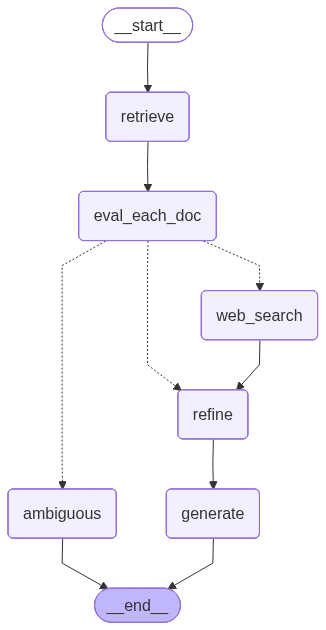

In [26]:
g = StateGraph(State)
g.add_node("retrieve", retreive)
g.add_node("eval_each_doc", eval_each_doc_node)
g.add_node("refine", refine)
g.add_node("generate", generate)
g.add_node("web_search", web_search_node)
# g.add_node("fail", fail_node)
g.add_node("ambiguous", ambiguous_node)


g.add_edge(START, "retrieve")
g.add_edge("retrieve", "eval_each_doc")

g.add_conditional_edges(
    "eval_each_doc",
    route_after_eval,
    {"refine": "refine", "web_search": "web_search", "ambiguous": "ambiguous"}
)
g.add_edge("web_search" ,"refine")
g.add_edge("refine", "generate")
g.add_edge("generate", END)
# g.add_edge("fail", END)

app = g.compile()
app

In [20]:
res = app.invoke(
    {
        "question": "Bias variance tradeoff",
        "docs": [],
        "good_docs": [],
        "verdict": "",
        "reason": "",
        "strips": [],
        "kept_strips": [],
        "refined_context": "",
        "answer": "",
    }
)

print("VERDICT:", res["verdict"])
print("REASON:", res["reason"])
print("\nOUTPUT:\n", res["answer"])

VERDICT: CORRECT
REASON: At least one retrieved chunk scored > 0.7.

OUTPUT:
 The bias-variance tradeoff is a crucial consideration in model selection and evaluation. It refers to the balance between two types of errors that can affect the predictive performance of a model:

1. **Bias**: This is the error resulting from the model's inability to capture the underlying relationship in the data accurately. High bias typically occurs with overly simplistic models that make strong assumptions, leading to systematic errors and underfitting.

2. **Variance**: This is the error resulting from sensitivity to small fluctuations in the training data. High variance is often seen in complex models that are flexible enough to fit noise in the data, leading to overfitting.

The tradeoff between bias and variance is such that:
- Increasing a model's complexity tends to decrease bias but increase variance.
- Reducing a model's complexity tends to increase bias but decrease variance.

Achieving optimal 

In [21]:
# Bias variance tradeoff
# AI news from last week
# What are attention mechanisms and why are they important in current models?